In [1]:
import sys
sys.path.append('../src')
import os

import foolbox as fa
import model
import torch
import torchvision
from data import loader
from data import preprocess
from foolbox import PyTorchModel, accuracy
from skimage.metrics import peak_signal_noise_ratio as psnr  # 计算信噪比
from utils import common

/guoxuan/anaconda3/envs/mytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from skimage.metrics import structural_similarity as ssim  # 计算图片平均结构相似度
import json

In [3]:
def load_dataset(path, is_train, is_shuffle, name, batch_size):
    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(88), 
            torchvision.transforms.ToTensor()
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_shuffle, num_workers=1
    )
    return data_loader

In [4]:
def evaluate(_m, ds):
    num_data = 0
    corrects = 0

    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

In [5]:
config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-SOC.json'))
model_name = config['model_name']
test_set = load_dataset('dataset', False, True, 'soc', 100)

m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

best_path = '/guoxuan/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth'

load test data set: 225it [00:00, 2243.82it/s]

load test data set: 2425it [00:00, 2638.57it/s]


In [6]:
m.load(best_path)
m.net.eval()

print(type(test_set))

<class 'torch.utils.data.dataloader.DataLoader'>


In [7]:
min_value, max_value = 0, 0
is_print_shape = False
for i, data in enumerate(test_set):
    images, labels, _ = data
    if not is_print_shape:
        print(images.shape, labels.shape)
        is_print_shape = True
    # print(images.min(), images.max())
    min_value = min(min_value, images.min().float())
    max_value = max(max_value, images.max().float())
print(min_value, max_value)

torch.Size([100, 2, 88, 88]) torch.Size([100])
0 tensor(11.7476)


In [8]:
train_set = load_dataset('dataset', True, True, 'soc', 100)

load train data set: 134603it [00:43, 3126.44it/s]


In [9]:
min_value, max_value = 0, 0
is_print_shape = False
for i, data in enumerate(train_set):
    images, labels, _ = data
    if not is_print_shape:
        print(images.shape, labels.shape)
        is_print_shape = True
    # print(images.min(), images.max())
    min_value = min(min_value, images.min().float())
    max_value = max(max_value, images.max().float())
print(min_value, max_value)

torch.Size([100, 2, 88, 88]) torch.Size([100])
0 tensor(16.7701)


In [11]:
m.device

device(type='cuda')

In [12]:
fmodel = PyTorchModel(m.net, bounds=(0, 16.7701), device=m.device)

# test_set = load_dataset('dataset', False, True, 'soc', 100)

#images, labels, _ = next(iter(test_set))

### 筛选100张分类正确的图片

In [13]:
correct_images = []
correct_labels = []

In [16]:
total, correct = 0.0, 0.0
for b, (inputs, labels, _) in enumerate(test_set):
    inputs, labels = inputs.to(m.device), labels.to(m.device)
    pred = fmodel(inputs).argmax(1)
    total += labels.shape[0]
    correct += (pred == labels).sum() # 统计预测正确的
    for i in range(len(pred)):
        if pred[i] == labels[i]:
            correct_images.append(inputs[i])
            correct_labels.append(labels[i])
    if correct >= 100:
        break

In [17]:
print("clean acc ", correct / total)

clean acc  tensor(0.9900, device='cuda:0')


In [18]:
correct_images = torch.stack(correct_images[:100])
correct_labels = torch.stack(correct_labels[:100])

In [19]:
linfPGD = fa.attacks.LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40,
                                                        random_start=True)

In [97]:
raw, clipped, success = linfPGD(fmodel, correct_images, correct_labels, epsilons=0.01)

In [99]:
# 筛选出对抗样本
advs = clipped[success]
ori_images = correct_images[success]
labels = correct_labels[success]
preds = fmodel(advs).argmax(-1) # preds
perbutations = advs - ori_images

In [100]:
type(advs), type(ori_images), type(labels), type(preds)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [101]:
advs[0].shape

torch.Size([2, 88, 88])

In [102]:
def convert_image(image):
    # print(image.shape)
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.ndim == 3:
        image = image.transpose((1, 2, 0))  # channnel first to channel last
    if image.shape[-1] == 1:
        image = image.squeeze(-1)  # 灰度图
    # print(images.shape)
    return image

In [74]:
import matplotlib.pyplot as plt

In [136]:
def show_image(title, samples, sample_advs, classes, perturbed, preds, labels, file_name,  n_display=4, img_shape=(88, 88)):
    n_display = min(n_display, samples.shape[0])  # 每一行显示 几张图片
    n_display = n_display * 2
    fig = plt.figure(figsize=(3 * n_display, 9))  # 宽度为2*n_display, 高度固定6
    plt.suptitle(title,fontsize=25)
    # classes = range(10)
    for idx in range(0, n_display, 2):
        # plt.subplots_adjust(wspace=1.0)
        
        plt.subplot(3, n_display, idx + 1)
        if idx == 0:
            plt.ylabel('original images',fontsize=20)
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(convert_image(samples[idx, 0,  ...].reshape(img_shape)), cmap='gray')
        plt.title("{}".format(classes[labels[idx].item()]), color="green", fontdict={"fontsize":20})
        
        # plt.subplots_adjust(wspace=0.5)
        
        plt.subplot(3, n_display, idx + 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(convert_image(samples[idx, 1,  ...].reshape(img_shape)), cmap='gray')
       
       
        # plt.subplots_adjust(wspace=1.0)
        
        plt.subplot(3, n_display, idx + n_display + 1)
        if idx == 0:
            plt.ylabel('perturbations',fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(convert_image(perturbed[idx, 0,  ...].reshape(img_shape)), cmap='gray')
        
        # plt.subplots_adjust(wspace=0.5)
        
        plt.subplot(3, n_display, idx + n_display + 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(convert_image(perturbed[idx, 1, ...].reshape(img_shape)), cmap='gray')
       
        # plt.subplots_adjust(wspace=1.0)
        
        plt.subplot(3, n_display, idx + 2 * n_display + 1)
        if idx == 0:
            plt.ylabel('adversarial images',fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(convert_image(sample_advs[idx, 0, ...].reshape(img_shape)), cmap='gray')
        plt.title("{}".format(classes[preds[idx].item()]), color="red", fontdict={"fontsize":20})
        
        # plt.subplots_adjust(wspace=0.5)
        
        plt.subplot(3, n_display, idx + 2 * n_display + 2)
        plt.imshow(convert_image(sample_advs[idx, 1, ...].reshape(img_shape)), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        

    fig.tight_layout()
    plt.savefig("{}.jpg".format(file_name), dpi=300)

In [137]:
target_name_soc = ('2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234')

In [138]:
import uuid

In [156]:
!pwd

5924.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/guoxuan/AConvNet-pytorch-main/notebook


In [153]:
start_index = 45

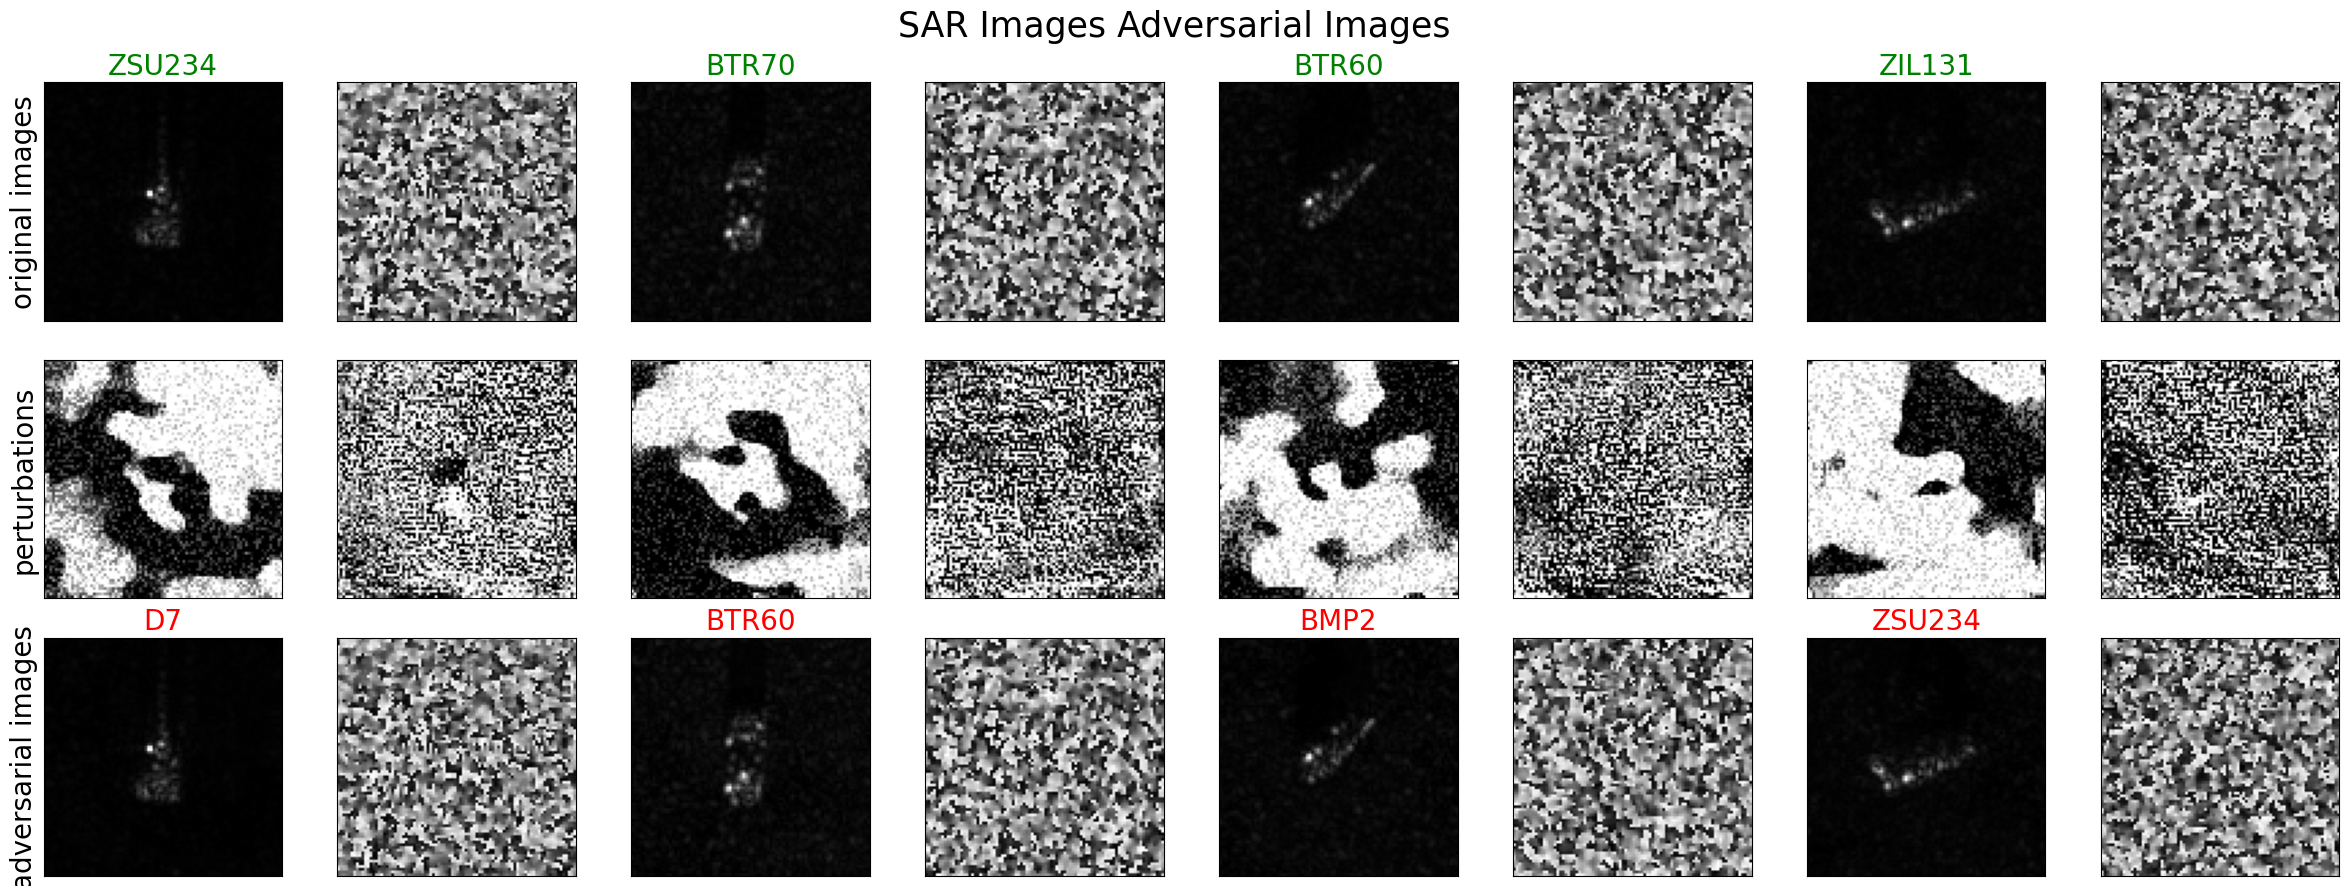

In [155]:
show_image("SAR Images Adversarial Images", ori_images[start_index:], advs[start_index:], target_name_soc, 
           perbutations[start_index:], preds[start_index:], labels[start_index:], str(uuid.uuid4()), n_display=4)

In [95]:
def count_integer_occurrences(nums):
    count_dict = {}
    for num in nums:
        if num in count_dict:
            count_dict[num] += 1
        else:
            count_dict[num] = 1
    return count_dict

In [14]:
lables_ints = [label.item() for label in labels]

In [15]:
occurrences = count_integer_occurrences(lables_ints)

In [16]:
print(occurrences)

{6: 9, 9: 13, 0: 13, 2: 13, 8: 15, 7: 3, 4: 7, 5: 11, 1: 8, 3: 8}


In [17]:
images = images.to(m.device)
labels = labels.to(m.device)

clean_acc = accuracy(fmodel, images, labels)

print('clean acc is:', clean_acc)

clean acc is: 1.0


In [18]:
## LinfPGD
linfPGD = fa.attacks.LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40,
                                                        random_start=True)


In [19]:
raw, clipped, success = linfPGD(fmodel, images, labels, epsilons=0.01)

In [20]:
print(round(success.float().mean(axis=-1).item(), 5))

0.88


In [25]:
# 计算相关的指标
def calculate_avg_norm_distortion_factor(raw_images, adv_images, is_success, data_range=12):
    """
        计算相应的指标
    """
    # 筛选出 真正的对抗样本
    select_raw_images = raw_images[is_success]
    select_adv_images = adv_images[is_success]

    # 没有对抗样本
    if select_raw_images.shape[0] == 0:
        return [0, 0, 0], 0, 0, [0, 0, 0]
        
    linf_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=float('inf'), dim=(1, 2, 3))
    l1_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=1, dim=(1, 2, 3))
    l2_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=2, dim=(1, 2, 3))

    linf_distortion_factor = (linf_avg_epsion
                              / torch.norm(select_raw_images, p=float('inf'), dim=(1, 2, 3))).mean().item()
    l1_distortion_factor = (l1_avg_epsion
                            / torch.norm(select_raw_images, p=1, dim=(1, 2, 3))).mean().item()
    l2_distortion_factor = (l2_avg_epsion
                            / torch.norm(select_raw_images, p=2, dim=(1, 2, 3))).mean().item()

    psnr_item = psnr(select_raw_images.cpu().numpy(), select_adv_images.cpu().numpy(), data_range=data_range)

    # ssim_item = ssim(select_raw_images.permute(0, 2, 3, 1).cpu().numpy(), select_adv_images.permute(0, 2, 3, 1).cpu().numpy(),
    #                      win_size=11, multichannel=True).item() # channel_last
    metric = dict()
    metric["l1_distortion_factor"] = l1_distortion_factor
    metric["l2_distortion_factor"] = l2_distortion_factor
    metric["linf_distortion_factor"] = linf_distortion_factor
    metric["psnr_item"] = psnr_item
    metric["l1_avg_epsion"] = l1_avg_epsion.mean().item()
    metric["l2_avg_epsion"] = l2_avg_epsion.mean().item()
    metric["linf_avg_epsion"] = linf_avg_epsion.mean().item()
    metric["ssim_item"] = None
    return metric

In [26]:
print(json.dumps(calculate_avg_norm_distortion_factor(images, clipped, success), indent = 4))

{
    "l1_distortion_factor": 0.005094336811453104,
    "l2_distortion_factor": 0.0033368756994605064,
    "linf_distortion_factor": 0.001589213847182691,
    "psnr_item": 62.934889580406654,
    "l1_avg_epsion": 125.82691955566406,
    "l2_avg_epsion": 1.0649960041046143,
    "linf_avg_epsion": 0.010000228881835938,
    "ssim_item": null
}


### 预测，显示对抗样本

In [27]:
print(images.shape, type(images), type(labels), labels.shape)

torch.Size([100, 2, 88, 88]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([100])


In [41]:
label_predicts = m.net(images) # 真实值
label_index = torch.argmax(label_predicts, dim=1)

In [31]:
print(type(clipped))

<class 'torch.Tensor'>


In [67]:
label_clipped_predicts = m.net(clipped) # 对抗样本预测输出
label_index_clipped = torch.argmax(label_clipped_predicts, dim=1)

In [34]:
label_clipped_predicts[0], label_predicts[0]

(tensor([ -1.5155,  -7.3406,  -0.2069,  -5.5829, -17.4595,   4.8655,   8.5269,
          -4.6270,  17.7941,   9.2036], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([  0.1910,  -3.8948,  -5.0212,  -2.2377, -13.1890,  -1.7426,  13.8711,
           2.3699,   6.8268,   6.0134], device='cuda:0',
        grad_fn=<SelectBackward0>))

In [35]:
target_name_soc = ('2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234')

In [37]:
from matplotlib import pyplot as plt

In [39]:
images[0].shape, images[0][0].shape

(torch.Size([2, 88, 88]), torch.Size([88, 88]))

In [62]:
def show_image(images, adv_images, ori_labels,  adv_labels, lable_dict, title, start, end, figsize_w, figsize_h):
    with torch.no_grad():
        row = end - start
        fig, axs = plt.subplots(row, 4, figsize=(figsize_w, figsize_h))
        fig.suptitle(title)
        for i in range(start, end):
            j = i - start
            label_soft_max = torch.softmax(label_predicts[i], dim = 0)
            top_5_values, top_5_indices = torch.topk(label_soft_max, k=5)
            result = ""
            for value, index in zip(top_5_values.tolist(), top_5_indices.tolist()):
                # print(index, type(index))
                result += f"{lable_dict[int(index)]}: {value:.6f}\n" 
            axs[j, 0].imshow(images[i][0].cpu().numpy(), cmap='gray')
            axs[j, 0].axis('off')
            axs[j, 0].set_title('ori class: ' + lable_dict[int(ori_labels[i])]  + "\n" + result)
            axs[j, 1].imshow(images[i][1].cpu().numpy(), cmap='gray')
            axs[j, 1].axis('off')

            label_soft_max = torch.softmax(label_clipped_predicts[i], dim = 0)
            top_5_values, top_5_indices = torch.topk(label_soft_max, k=5)
            result = ""
            for value, index in zip(top_5_values.tolist(), top_5_indices.tolist()):
                # print(index, type(index))
                result += f"{lable_dict[int(index)]}: {value:.6f}\n" 
            axs[j, 2].imshow(adv_images[i][0].cpu().numpy(), cmap='gray')
            axs[j, 2].axis('off')
            axs[j, 2].set_title('adv class: ' + lable_dict[int(adv_labels[i])]+ "\n" +  result)
            axs[j, 3].imshow(adv_images[i][1].cpu().numpy(), cmap='gray')
            axs[j, 3].axis('off')

    plt.tight_layout()
    plt.show()

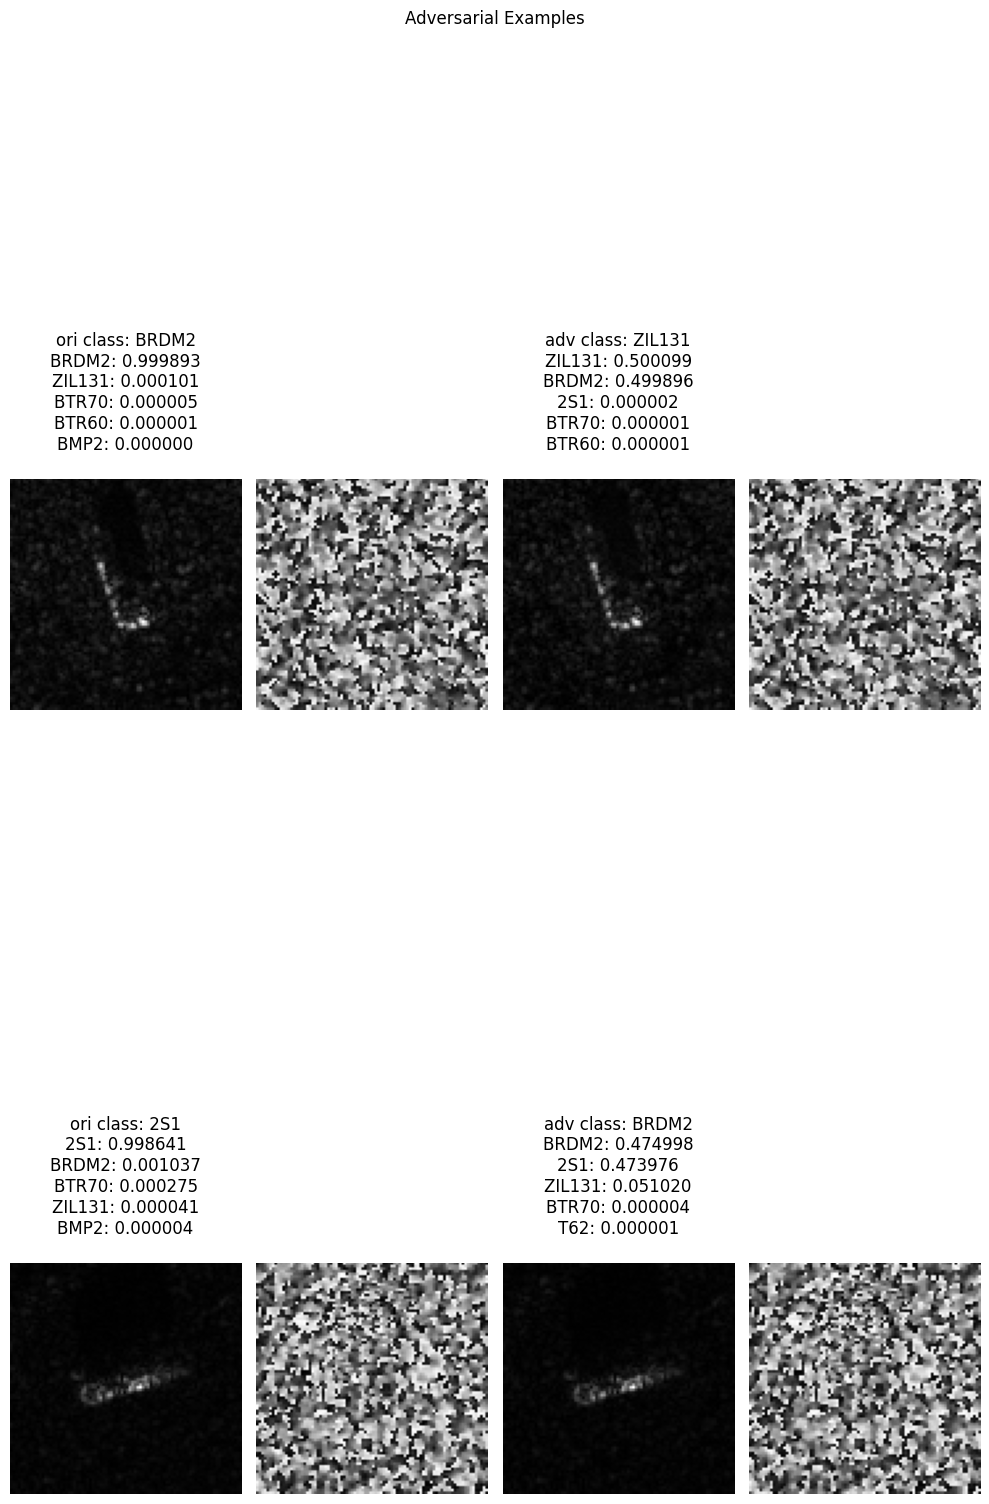

In [68]:
show_image(images, clipped, label_index,  label_index_clipped, target_name_soc, "Adversarial Examples", 83, 85, 10, 20)

### L0BrendelBethgeAttack

In [104]:
L0BrendelBethgeAttack = fa.attacks.L0BrendelBethgeAttack(init_attack=None, overshoot=1.1, steps=100, lr=0.001, 
                                                         lr_decay=0.5, lr_num_decay=20, momentum=0.8,
                                                         tensorboard=False, binary_search_steps=10)

In [105]:
raw, clipped, success = L0BrendelBethgeAttack(fmodel, images, labels, epsilons=0.01)

/home/dzk/anaconda/envs/aconvnet-pytorch/lib/python3.10/site-packages/foolbox/attacks/blended_noise.py:85: UserWarning: LinearSearchBlendedUniformNoiseAttack failed to draw sufficient random inputs that are adversarial (88 / 100).
  warnings.warn(


AssertionError: 

In [ ]:
print(round(success.float().mean(axis=-1).item(), 5))

### foolbox.attacks.LInfFMNAttack

In [64]:
LinfFMNAttack = fa.attacks.LInfFMNAttack()

In [65]:
raw, clipped, success = LinfFMNAttack(fmodel, images, labels, epsilons=0.008)

In [66]:
print(round(success.float().mean(axis=-1).item(), 5))

0.83


In [69]:
print(json.dumps(calculate_avg_norm_distortion_factor(images, clipped, success), indent = 4))

{
    "l1_distortion_factor": 0.002012348035350442,
    "l2_distortion_factor": 0.0014196689007803798,
    "linf_distortion_factor": 0.0007016215822659433,
    "psnr_item": 69.80176717312659,
    "l1_avg_epsion": 49.66346740722656,
    "l2_avg_epsion": 0.4526897370815277,
    "linf_avg_epsion": 0.004417428746819496,
    "ssim_item": null
}


In [58]:
print(type(clipped[0]))

<class 'torch.Tensor'>


In [59]:
ori_min, ori_max = 0, 0
for image in images:
    ori_min = min(ori_min, image.min().float())
    ori_max = max(ori_max, image.max().float())
print(ori_min, ori_max)

0 tensor(8.7718, device='cuda:0')


In [60]:
nan_count = 0
min_tensor_value, max_tensor_value  = 0, 0
for clip in clipped:
    if torch.isnan(clip).any():
        nan_count = nan_count + 1
    min_tensor_value = min(min_tensor_value, clip.min().float())
    max_tensor_value = max(max_tensor_value, clip.max().float())
print(min_tensor_value, max_tensor_value)
print(nan_count)

0 tensor(8.7638, device='cuda:0')
0


In [61]:
print(images.shape, clipped.shape)

torch.Size([100, 2, 88, 88]) torch.Size([100, 2, 88, 88])


In [62]:
print(success, success.shape)

tensor([ True,  True, False,  True,  True, False,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0') torch.Size([100])


In [37]:
print((images[success]).shape)

torch.Size([96, 2, 88, 88])


In [122]:
images.shape

torch.Size([100, 2, 88, 88])

In [124]:
images.permute(0, 2, 3, 1).cpu().numpy().shape

(100, 88, 88, 2)

In [125]:
images.shape

torch.Size([100, 2, 88, 88])

In [131]:
import json

In [143]:
print(json.dumps(calculate_avg_norm_distortion_factor(images, clipped, success), indent=4))

{
    "l1_distortion_factor": 0.0022454392164945602,
    "l2_distortion_factor": 0.0015973059926182032,
    "linf_distortion_factor": 0.0008001318201422691,
    "psnr_item": 68.71451552361943,
    "l1_avg_epsion": 55.52500915527344,
    "l2_avg_epsion": 0.5102861523628235,
    "linf_avg_epsion": 0.00504206120967865
}
